# Snakemake Dimuon Tutorial

[Snakemake](https://snakemake.readthedocs.io/en/stable/) is a popular *workflow management system* designed to create reproducible and scalable analyses and data processing pipelines.

Its name is composed of two words:
 * **Snake**: because it inherits the language to define the workflows from Python, but extends it to improve the readability of the workflows by minimizing the boilerplates;
 * **make**: because it takes inspiration from GNU Make to implement a dependency chain to regenerate only those dependencies that actually changed, while letting the cached artifacts untouched. This feature makes it extremely suitable for focussing on long pipelines and developing, testing and tuning multiple times a small step, and then seaminglessly plug into the whole workflow and see the global effect.

**Snakemake** is designed to easily scale across distributed resources. Batch systems, grids and clouds have been interfaced with Snakemake to execute the steps of the workflow remotely. This aspect will not be covered in this tutorial, but you may check out [CERN's reana](reana.cern.ch) and AWS [Tibanna](https://tibanna.readthedocs.io/en/latest/) for cloud-native integrations, and [Snakemake profiles](https://github.com/snakemake-profiles/doc) for instructions related to batch systems (such as HTCondor and Slurm).

In this tutorial we will focus on the logics to define a workflow and on tips and tricks to employ a variety of other tools, such as bash, python and jupyter, to define the "jobs".




## Directed Acyclic Graphs

A workflow is represented in Snakemake as a Directed Acyclic Graph (DAG). 
Most often we will use the word DAG and workflows as synonyms, even though you can thing as DAGs as a generic concept of graph theory describing a particular kind of workflow.

But what do we mean by *Directed Acyclic Graphs*? Let's start discussing these three words in reverse order:
 * **Graph**: In general, a *graph* is a collection of nodes, with edges defining the "connections" between nodes, in the context of workflow management,
   * *Nodes* represent *tasks* performed in a single *job*;
   * *Edges* represent the dependencies of a job on the output of another;
 * **Acyclic**: a graph is acyclic if there are no loops defined by the edges, in the context of workflow management this means that a dependency loops are not admitted: the job *A* cannot depend on the output of job *B* if *B* depends on the output of job *A*.
 * **Directed**: in a *directed graph*, edges have a direction. This simply implies that the relation "depends on" is not symmetric between the parties.

We will use the Python Image Library (PIL) to visualize DAGs througout the tutorial. 

In [1]:
from PIL import Image

## Installing Snakemake in a virtual environment

Snakemake can be [installed](https://snakemake.readthedocs.io/en/stable/getting_started/installation.html) with several package managers, the recommended ones are mamba and bioconda which are flavors of conda. 
This tutorial has been designed to run on CERN Swan that does not support (yet?) user's defined kernels. 
Hence, we will use PyPI and its command-line interface `pip`.

To avoid cluttering your global namespace, let's create a virtual environment with `venv` and let's install Snakemake there.
Then we will install `snakemake`in the newly created environment and call it with the `-v` flag to print its version in the notebook.

Note that here and afterwards, we will invoke snakemake as `<name of the venv env>/bin/snakemake` in other setups you can avoid this by `activate`-ing your environment (`source <name of the venv env>/bin/activate` and then simply `snakemake`).

In [84]:
%%bash 

# Remove the virtual environment if it exists and re-create  it
rm -rf en
python3 -m venv env

# Install snakemake in the new virtual env
env/bin/python3 -m  pip install -qU snakemake<8.0 pulp==2.7.0

# Print the version of the installed Snakemake
env/bin/snakemake -v

7.32.4


bash: line 7: 8.0: No such file or directory


## Hello world!

Let's start from the simplest possible workflow: a single task, without dependencies, executed once.
It's pretty useless, agreed... but it's a way to start discussing the syntax for defining a task, or, in Snakemake jargon, a *rule*.

According to the official [documentations](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html), *"a Snakemake **workflow** defines a data analysis in terms of **rules** that are specified in a **Snakefile**"*.

Let's start discussing these three concepts:
 * a *Snakefile* is the equivalent of a Makefile in GNU Make. It defines the tasks and the dependencies between the tasks. It is defined using a language that extends Python: if a code snippet is valid in Python it will also be valid in  a Snakefile, but not viceversa.
 * a *rule* define a single task, possibly executed multiple times on different outputs or with different configurations, exposing to Snakemake the files it depends on, the outputs it generates and the computing resources it needs to run.
 * the *workflow* is the ensemble of tasks defined by Snakemake based on the Snakefile, ensuring that the dependencies of each task are satisfied before the task is executed and refreshing all the outputs depending on an updated dependency.

Let's see our first example of a Snakefile defining a workflow with a single rule.

We will name the Snakefile `Snakefile.helloworld` and the single rule in it `greetings`. 
The task defined by the rule `greetings` will simply be printing out some text relyong on the shell command `echo`.


In [3]:
%%writefile Snakefile.helloworld

rule greetings:
  shell:
    "echo 'Hello, snakemakers'"


Overwriting Snakefile.helloworld


Note that `rule` and `shell` are keywords added to the Snakemake language on top of Python.
The line `rule greetings:` initialize a new code block defining the dependencies, the output, the requested resources, the configuration and the task of the `greetings` rule.

The line `shell:` indicates we are defining the task using shell (typically `bash`) language.

That's it. You can now execute this workflow by calling snakemake and specifying the name of the Snakefile and maximal number of cores Snakemake can use.

In the following examples we will always run on a single process (`-j 1`), but here we will ask Snakemake to use all the available cores (`-j all`).
This can be dangerous in some environment. On SWAN for example, running on a [Kubernetes](https://kubernetes.io/docs/concepts/overview/what-is-kubernetes/) cluster, Snakemake finds the number of cores of the underlying virtual machine, rather than the total amount of CPUs allocated by Kubernetes to our activity. 
In this case, the Linux kernel would [scale down the CPU usage](https://kubernetes.io/docs/concepts/configuration/manage-resources-containers/#how-pods-with-resource-limits-are-run) to the maximum allowed and the larger number of threads would only result in larger overhead.

So the bottom-line is you may use `-j all` to run Snakemake on your own resources, but as the environment you are running on is somewhat shared, you should rather switch on your brain and fix the number of parallel tasks to an optimimum for your specific workflow and environment. 

> **Note on parallel execution.** Snakemake does not change anything of how the single task is executed. Don't expect it to automagically parallelize your code! However it can parallelize the execution of indepedendent tasks whose dependencies are already satisfied on multiple processors.

In [4]:
!env/bin/snakemake -j all -s Snakefile.helloworld

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 28
Rules claiming more threads will be scaled down.
Job stats:
job          count
---------  -------
greetings        1
total            1

Select jobs to execute...

[Sun Feb 18 18:28:40 2024]
rule greetings:
    jobid: 0
    reason: Rules with neither input nor output files are always executed.
    resources: tmpdir=/tmp

Hello, snakemakers
[Sun Feb 18 18:28:40 2024]
Finished job 0.
1 of 1 steps (100%) done
Complete log: .snakemake/log/2024-02-18T182839.282482.snakemake.log


### Logging

In the example above, the string we printed out with `echo` gets embedded in the Snakemake output, defining how tasks are queued and monitoring the status of the workflow execution. This might be extremely suboptimal when multiple tasks are executed in parallel, or workflow of thousands of tasks are run.

Snakemake provides a `log:` configuration key that can be used to identify the log file. 
Log files are treated by Snakemake in a very similar way to output files, but they are not deleted upon failure of the task as they may be useful to identify the error.


In [5]:
%%writefile Snakefile.helloworld

rule greetings:
  log: "greetings.log"
  shell:
    "echo 'Hello, snakemakers' > {log}"


Overwriting Snakefile.helloworld



Let's execute it as above, and let's print the content of the `greetings.log` file.

In [6]:
!env/bin/snakemake -j 1 -s Snakefile.helloworld
!cat greetings.log

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job          count
---------  -------
greetings        1
total            1

Select jobs to execute...

[Sun Feb 18 18:28:42 2024]
rule greetings:
    log: greetings.log
    jobid: 0
    reason: Rules with neither input nor output files are always executed.
    resources: tmpdir=/tmp

[Sun Feb 18 18:28:42 2024]
Finished job 0.
1 of 1 steps (100%) done
Complete log: .snakemake/log/2024-02-18T182841.602091.snakemake.log
Hello, snakemakers


Note how we are  using elements of the rule configuration to define the task. The `{log}` string will be replaced by the value of the `log` variable as defined above.

It may be a good idea to *name* the log files to improve the readability of the rule. 
Naming also enables defining multiple objects for the same categories, for example one may define different logs to redirect the stdout and stderr streams, or different levels of logs  (though this might be exquisitely application dependent!).

In [7]:
%%writefile Snakefile.helloworld

rule greetings:
  log: 
    echo_output="greetings.log",
    some_other_log="other.log"

  shell:
    "echo 'Hello, snakemakers' > {log.echo_output}"


Overwriting Snakefile.helloworld


Let's execute  this hello world one more time...

In [8]:
!env/bin/snakemake -j 1 -s Snakefile.helloworld
!cat greetings.log

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job          count
---------  -------
greetings        1
total            1

Select jobs to execute...

[Sun Feb 18 18:28:44 2024]
rule greetings:
    log: greetings.log, other.log
    jobid: 0
    reason: Rules with neither input nor output files are always executed.
    resources: tmpdir=/tmp

[Sun Feb 18 18:28:44 2024]
Finished job 0.
1 of 1 steps (100%) done
Complete log: .snakemake/log/2024-02-18T182843.555434.snakemake.log
Hello, snakemakers


### Hello world, but in Python

Using the shell to define tasks is most common as usually tasks are defined by full-fledged third-party applications.
For smaller tasks, however, it may be more practical to write directly in Python.

This can be achived by using the  `run:` directive instead of `shell:`.
In Python, you will be able to access directly the `log` object (and similarly the `input`, `output` and `wildcards` we will introduce later.

In [9]:
%%writefile Snakefile.helloworld

rule greetings:
    log: 
        echo_output="greetings.log",
    run:
        print("Hello! This is python!", file=open(log.echo_output, "w"))


Overwriting Snakefile.helloworld


Let's execute the workflow with the usual command, and let's print once more the content of `greetings.log`.

In [10]:
!env/bin/snakemake -j 1 -s Snakefile.helloworld
!cat greetings.log

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job          count
---------  -------
greetings        1
total            1

Select jobs to execute...

[Sun Feb 18 18:28:46 2024]
rule greetings:
    log: greetings.log
    jobid: 0
    reason: Rules with neither input nor output files are always executed.
    resources: tmpdir=/tmp

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Select jobs to execute...
[Sun Feb 18 18:28:47 2024]
Finished job 0.
1 of 1 steps (100%) done
Complete log: .snakemake/log/2024-02-18T182845.514034.snakemake.log
Hello! This is python!


## Data analysis is better with data!

Let's move away from the Hello World example discussed above by starting playing with some data.
We will start with the CERN Open Data dataset obtained from the SingleMu trigger line of the CMS experiment in 2011 and processed to contain muon pairs (DiMuons, in jargon).

All details on the chosen dataset are available at the link [opendata.cern.ch/record/5202](https://opendata.cern.ch/record/5202).

Let's begin building our analysis workflow by obtaining a local copy of the data.
This will be our first task.

We will use the shell command `wget` to retrieve the CSV files from the OpenData portal.

> **Exercise.** You may try to reimplement this task using Python. You may use the [`requests`](https://requests.readthedocs.io/en/latest/) or [`httpx`](https://www.python-httpx.org/) libraries, or you may rely directly on the [ability of pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) to retrieve remote datasets.

In [11]:
%%writefile Snakefile.dimuon

rule get_file:
    output:
      csv_file="dimuon.csv"
      
    shell:
        "wget https://opendata.cern.ch/record/5202/files/Dimuon_SingleMu.csv -qO {output.csv_file}"


Overwriting Snakefile.dimuon


Let's execute a single-task workflow for the last time! Fire!

In [12]:
!env/bin/snakemake -j 1 -s Snakefile.dimuon

Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2024-02-18T182849.117240.snakemake.log


### Counting the number of lines in the CSV file
Let's add a second step to our workflow with an additional rule.
Let's say we want to count the number of lines in the dowloaded CSV file as a proxy of the number of dimuons (plus some header lines).

We will use the [`wc` command](https://it.wikipedia.org/wiki/Wc_(Unix)).

In [13]:
%%writefile Snakefile.dimuon

rule count_lines:
    input:
      csv_file="dimuon.csv"
      
    shell:
        "cat {input.csv_file} | wc"


rule get_file:
    output:
      csv_file="dimuon.csv"
      
    shell:
        "wget https://opendata.cern.ch/record/5202/files/Dimuon_SingleMu.csv -qO {output.csv_file}"


Overwriting Snakefile.dimuon


Let's draw the resulting DAG!

Building DAG of jobs...


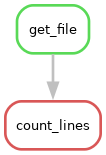

In [14]:
!env/bin/snakemake -s Snakefile.dimuon --forceall --dag | dot -Tpng > dag.png
Image.open("dag.png")

And let's execute it! It will download the CSV file from the remote location and it will count its lines by running `wc`.

Note that before downloading the file, it checks whether it is already available locally. 

If the file is available, and no `--forceall` or `-F` flags are applied, then it will not download the dataset once again.

In [15]:
!env/bin/snakemake -j 1 -s Snakefile.dimuon

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job            count
-----------  -------
count_lines        1
total              1

Select jobs to execute...

[Sun Feb 18 18:28:53 2024]
rule count_lines:
    input: dimuon.csv
    jobid: 0
    reason: Rules with a run or shell declaration but no output are always executed.
    resources: tmpdir=/tmp

  83762   83762 11806904
[Sun Feb 18 18:28:53 2024]
Finished job 0.
1 of 1 steps (100%) done
Complete log: .snakemake/log/2024-02-18T182852.371730.snakemake.log


### Adding a second dataset

Let's add a second dataset to make our DAG more interesting. 

We will use another DiMuon dataset from CMS, but this time we will take the 2010 dataset.
You may get additional details on this dataset at  the link [opendata.cern.ch/record/303](https://opendata.cern.ch/record/303/).

The simplest thing we can do is to define two separate rules for downloading the 2010 and 2011 data.
They will create local files with the datataking year in the filename that can be used by the downstream steps to identify which rule has to be invoked to (re-)generate each local copy of the dataset.

We will introduce also the [`expand` keyword](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#the-expand-function) that enables defining a list of items differing for some token only. In this case the year of datataking.

In [16]:
%%writefile Snakefile.dimuon

rule count_lines:
    input:
        csv_file=expand("dimuon{year}.csv", year=[2010, 2011])
      
    shell:
        "cat {input.csv_file} | wc"


rule get_file_2011:
    output:
      csv_file="dimuon2011.csv"
      
    shell:
        "wget https://opendata.cern.ch/record/5202/files/Dimuon_SingleMu.csv -qO {output.csv_file}"


rule get_file_2010:
    output:
      csv_file="dimuon2010.csv"
      
    shell:
        "wget https://opendata.cern.ch/record/303/files/dimuon.csv -qO {output.csv_file}"


Overwriting Snakefile.dimuon


Let's show the DAG. 

Building DAG of jobs...


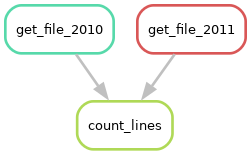

In [17]:
!env/bin/snakemake -s Snakefile.dimuon --forceall --dag | dot -Tpng > dag.png
Image.open("dag.png")

So this is ok and it works, but it is inelegant in too many ways to be the solution we want to adopt.

Let's list some bad ideas:
 * we have separate rules performing basically the same task: *downloading a CSV dataset*. If then we add another per year of datataking the number of copy-pasted rules would explode making it tedious to maintain the workflow. We would better have one rule with different arguments and some mechanism to map a data-taking year to a remote  URL from which to pick the dataset.
 * we are manually typing at least twice the years of data-taking. If we are adding one dataset, we have to manually  modify the rules, which is not nice...

Fortunately we are writing in Python inside our Snakefile and we can do pretty much everything including defining a mapping of the datataking years towards the URL and then use that mapping throughout the rules. 

We will create a new DATASETS mapping (a `dict`) associating the year (as a string!) to the URL.

```python
DATASETS = {
    "2010": "https://opendata.cern.ch/record/303/files/dimuon.csv",
    "2011": "https://opendata.cern.ch/record/5202/files/Dimuon_SingleMu.csv",
}
```

Then we need to read this mapping from the upstream and downstream rules. 

Let's start with the `count_lines` function. Everything is rather simple here, we just have to replace
```python
    input:
        csv_file=expand("dimuon{year}.csv", year=[2010, 2011])
```
with
```python
    input:
        csv_file=expand("dimuon{year}.csv", year=DATASETS.keys())
```


For resolving the mapping in the `get_file` rule, instead, we need an additional trick.

The rule will depend on a parameter, the URL, that can be inferred based on the name of the pulled `output` file. 
When some rule will request to generate the file `dimuon2011.csv`, Snakemake must define the parameter URL as obtained from the mapping DATASETS where the key is `"2011"`. 

Do define this mechanism we need three new concepts:
 * **wildcards** ([link to the docs](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#wildcards));
 * **parameters** ([link to the docs](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#non-file-parameters-for-rules));
 * **input functions** ([link to the docs](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#input-functions)).


#### Wildcards
Wildcards are used to generalize rules extracting tokens from the paths of the outputs to infer parameters and inputs of a given rule. 

In our example, we will define the rule `get_file` to generate an output named `dimuon{year}.csv`. 
`year` is the wildcard. When a downstream rule will try request to (re-)generate `dimuon2011.csv`, the wildcard `year` will get assigned the value `"2011"`.

> **Pro Tip.** If you speak regex, be aware it is good practice to specify what kind of token you expect in a wildcard. For example, in this way we know that the datataking year is composed of exactly for digits, so we could specify that the output filename of our rule is `dimuon{year,[0-9]{4}}.csv` or  `dimuon{year,\d{4}}.csv`. If we accept our code will break compatibility for data taking periods in 75 years (which I do personally consider acceptable), we can force the first two digits to be `"20"` by writing `dimuon{year,20\d{2}}.csv`.
> **Regular expression** are powerful to constraint the tokens but they are considered as black magic by many people, so beware of the readability loss if you decide to adopt them.

#### Parameters (`params`)
Parameters are non-file inputs to the rule. A parameter can be built on top of a wildcard and used to define the task (while wildcards alone cannot be used as inputs).
In our case, we will define a parameter named `url` obtained from the wildcard `year` resolving the mapping `DATASETS`.

#### Input functions 
The resolution of the mapping requires some logic beyond string formatting. We can inject such logic in a function taking as an input a dictionary of wildcards and returning a string and using that function a "parameter". 

Lambda functions are particularly well suited for this kind of task!

Wrapping all together, we will have our new `get_file` rule defined as:
```python

rule get_file:
    output:
      csv_file="dimuon{year}.csv"   ## {year} here is a wildcard!

    params:  ## params define non-file inputs
        url=lambda wildcards: DATASETS[wildcards['year']]   
        ## url is obtained with a function, resolving DATASETS mapping.

    shell:
        "wget {params.url} -qO {output.csv_file}"
        ##     ^^^^^^^^^^ the parameter url is then used to define the task 
```


In [18]:
%%writefile Snakefile.dimuon

DATASETS = {
    "2010": "https://opendata.cern.ch/record/303/files/dimuon.csv",
    "2011": "https://opendata.cern.ch/record/5202/files/Dimuon_SingleMu.csv",
}

def resolve_dataset(wildcards):
    return DATASETS[wildcards['year']]


rule count_lines:
    input:
        csv_file=expand("dimuon{year}.csv", year=DATASETS.keys())
      
    shell:
        "cat {input.csv_file} | wc"


rule get_file:
    output:
      csv_file="dimuon{year}.csv"

    params:
        url=resolve_dataset
        ## Or alternatively, 
        # url=lambda w: DATASETS[w['year']]

    shell:
        "wget {params.url} -qO {output.csv_file}"


Overwriting Snakefile.dimuon


Let's display the DAG. Now there is only a single `get_file` task, but it gets executed twice, once with wildcard `year = "2010"` and once with `year = "2011"`.

Building DAG of jobs...


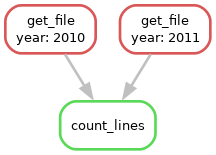

In [19]:
!env/bin/snakemake -s Snakefile.dimuon --forceall --dag | dot -Tpng > dag.png
Image.open("dag.png")

Let's fire it!

In [20]:
!env/bin/snakemake -j 1 -s Snakefile.dimuon --forceall

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job            count
-----------  -------
count_lines        1
get_file           2
total              3

Select jobs to execute...

[Sun Feb 18 18:28:58 2024]
rule get_file:
    output: dimuon2011.csv
    jobid: 2
    reason: Forced execution
    wildcards: year=2011
    resources: tmpdir=/tmp

[Sun Feb 18 18:29:03 2024]
Finished job 2.
1 of 3 steps (33%) done
Select jobs to execute...

[Sun Feb 18 18:29:03 2024]
rule get_file:
    output: dimuon2010.csv
    jobid: 1
    reason: Forced execution
    wildcards: year=2010
    resources: tmpdir=/tmp

[Sun Feb 18 18:29:06 2024]
Finished job 1.
2 of 3 steps (67%) done
Select jobs to execute...

[Sun Feb 18 18:29:06 2024]
rule count_lines:
    input: dimuon2010.csv, dimuon2011.csv
    jobid: 0
    reason: Input files updated by another job: dimuon2011.csv, dimuon2010.csv
    resourc

## Writing tasks for Snakemake

So far we discussed how Snakemake is used to connect existing applications to perform tasks as part of a single workflow. 
Now we will turn the perspective the other way, on the development of the tasks. 

We will consider three examples of tasks:
 * developing a Python applications configurable with command-line arguments and environmental variables and integrating it in snakemake via the shell
 * developing a Jupyter notebook configurable with environmental variables and plug it in the workflow;
 * developing a custom, snakemake-specific task taking inputs directly from the snakemake rule using the `snakemake` object.

While we are focussing here on Python, notice the first approach is completely general, and that for the third approach there are many wrappers for many different languages to directly access, from the task, to the rule configuration.

### Snakemake-independent tasks: using environment variables and arguments 

The first method we will explore to integrate custom steps in a Snakemake workflow is conceptually  the simplest one.

We will write a custom application designed to be configured with its command line arguments and some environmental variables, and then we will plug it in the Snakemake workflow by calling it from the shell. 

This method has the advantage of producing an application that can be used independently of snakemake, it can be developed and debugged using IDEs that do not know snakemake or the other tasks and can be released to a larger audience than that interested in your specific workflow. 

On the other hand, as we will see, the complexity of the inputs and of the configuration might be limited by the expressivity one may reach with command line arguments and env vars.

Also, integrating the two requires some gymnastics and boilerplate which you may be happy to avoid if you are writing some tasks that only make sense within your specific workflow. 

#### ArgumentParser
Command-line arguments can be read using the [`sys` module](https://docs.python.org/3/library/sys.html) in Python, 
exposing them as the [`sys.argv` list](https://docs.python.org/3/library/sys.html#sys.argv). The `sys.argv` mechanism, though, is pretty rough. There is no documentation, no flags, no validation of the arguments. 
If you think `sys.argv` may be good for your application, there are good chances wrapping directly your task in Snakemake would be cleaner and more readable. 

A very good alternative is provided by the module [`argparse` with its object `ArgumentParser`](https://docs.python.org/3/library/argparse.html).

We will not go in any detail on `argparse` as it would require another Tutorial the same lenght as this one on Snakemake, but you got a pointer.

We will define a parser for the input arguments expecting one or more CSV input files. 

```python
from argparse import ArgumentParser

parser = ArgumentParser("drawhist.py")
parser.add_argument("input_files", nargs='+', help="Input CSV files")
args = parser.parse_args()
```

To cut the number of examples we will be discussing here, the output filename will be passed as an environmental variable, instead.

```python
import os

OUTPUT_FILE = os.environ.get("OUTPUT_FILE", "fig.png")
```

Then we can build some fancy logics connecting a list of CSV input files to an output figure. 

For example, with a greatest effort for may fantasy, I confess, we may plot a histogram.

In [21]:
%%writefile drawhist.py

## Standard Python Libraries
##   ArgumentParser is for taking inputs from the command line
from argparse import ArgumentParser
##   os is for taking inputs from the environment variables
import os

## Numerical python ecosystem: numpy, pandas and pyplot
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

## Retrieve the output file name from OUTPUT_FILE
OUTPUT_FILE = os.environ.get("OUTPUT_FILE", "fig.png")

## Retrieve the input filenames (CSV files) from the command line
parser = ArgumentParser("drawhist.py")
parser.add_argument("input_files", nargs='+', help="Input CSV files")
args = parser.parse_args()

## Loop over the CSV files, convert and store them as DataFrames 
dataframes = []
for fname in args.input_files:
    dataframes.append(pd.read_csv(fname)[["M"]])

## Concatenate all the input datasets and create the histogram
pd.concat(dataframes).hist("M", bins=np.linspace(1, 120, 121))

## Store the histogram in a file
plt.savefig(OUTPUT_FILE)

Overwriting drawhist.py


As promised, we can test our small script running it independently of Snakemake.


In [22]:
!OUTPUT_FILE=outputhist.png env/bin/python3 drawhist.py dimuon2011.csv dimuon2010.csv 

And then integrate it in our workflow in its dedicated `make_hist` rule.

```python
rule make_hist:
    input:
        csv_file=expand("dimuon{year}.csv", year=[2010, 2011])

    output:
        figure="hist.png"
      
    shell:
        "OUTPUT_FILE={output.figure} "
        "python3 drawhist.py {input.csv_file}"

```

Or, alternatively, using a multi-line string for the shell command, if you prefer.

```python
rule make_hist:
    input:
        csv_file=expand("dimuon{year}.csv", year=[2010, 2011])

    output:
        figure="hist.png"
      
    shell:
        """
        OUTPUT_FILE={output.figure} \
        python3 drawhist.py {input.csv_file}
        """
```

Note how we are passing the values configured for the input and output to out script, passing through the command line for the input and through the `OUTPUT_FILE` environmental variable for the output.


In [23]:
%%writefile Snakefile.dimuon

DATASETS = {
    "2010": "https://opendata.cern.ch/record/303/files/dimuon.csv",
    "2011": "https://opendata.cern.ch/record/5202/files/Dimuon_SingleMu.csv",
}


rule make_hist:
    input:
        csv_file=expand("dimuon{year}.csv", year=DATASETS.keys())

    output:
        figure="hist.png"
      
    shell:
        """
        OUTPUT_FILE={output.figure} \
        python3 drawhist.py {input.csv_file}
        """


rule get_file:
    output:
      csv_file="dimuon{year}.csv"

    params:
        url=lambda w: DATASETS[w['year']]
      
    shell:
        "wget {params.url} -qO {output.csv_file}"


Overwriting Snakefile.dimuon


Let's plot and execute this new DAG.

Building DAG of jobs...


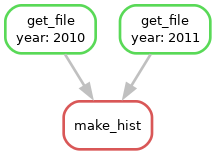

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job          count
---------  -------
get_file         2
make_hist        1
total            3

Select jobs to execute...

[Sun Feb 18 18:29:17 2024]
rule get_file:
    output: dimuon2011.csv
    jobid: 2
    reason: Forced execution
    wildcards: year=2011
    resources: tmpdir=/tmp

[Sun Feb 18 18:29:21 2024]
Finished job 2.
1 of 3 steps (33%) done
Select jobs to execute...

[Sun Feb 18 18:29:21 2024]
rule get_file:
    output: dimuon2010.csv
    jobid: 1
    reason: Forced execution
    wildcards: year=2010
    resources: tmpdir=/tmp

[Sun Feb 18 18:29:24 2024]
Finished job 1.
2 of 3 steps (67%) done
Select jobs to execute...

[Sun Feb 18 18:29:24 2024]
rule make_hist:
    input: dimuon2010.csv, dimuon2011.csv
    output: hist.png
    jobid: 0
    reason: Input files updated by another job: dimuon2010.csv, dimuon2011.csv
  

In [24]:
!env/bin/snakemake -s Snakefile.dimuon --forceall --dag | dot -Tpng > dag.png
display(Image.open("dag.png"))
!env/bin/snakemake -j 1 -s Snakefile.dimuon --forceall

Now if we want to generate for every run the images in format  `png`, `pdf` and `jpg`, we can add a new rule (the default name for the *entry-point rule* is `all` and must be the first rule defined in the Snakefile.

```python
rule all:
    input:
        png="hist.png",
        pdf="hist.pdf",
        tiff="hist.jpg",

```

This automatically recreates the DAG executing three times the make_histogram step. 

Someone may object that filling three times the histograms just for the purpose of saving it in a different format is a waste of computing resources (and it is true). But we will leave coding optimizations to the reader. 

In [25]:
%%writefile Snakefile.dimuon

DATASETS = {
    "2010": "https://opendata.cern.ch/record/303/files/dimuon.csv",
    "2011": "https://opendata.cern.ch/record/5202/files/Dimuon_SingleMu.csv",
}

rule all:
    input:
        png="hist.png",
        pdf="hist.pdf",
        tiff="hist.jpg",

rule make_hist:
    input:
        csv_file=expand("dimuon{year}.csv", year=DATASETS.keys())

    output:
        figure="hist.{fmt}"
      
    shell:
        "OUTPUT_FILE={output.figure} "
        "python3 drawhist.py {input.csv_file}"


rule get_file:
    output:
      csv_file="dimuon{year}.csv"

    params:
        url=lambda w: DATASETS[w['year']]
      
    shell:
        "wget {params.url} -qO {output.csv_file}"


Overwriting Snakefile.dimuon


Building DAG of jobs...


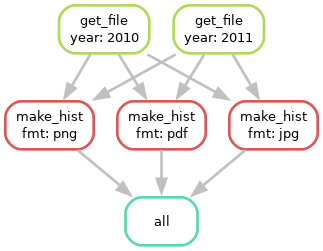

In [26]:
!env/bin/snakemake -s Snakefile.dimuon --forceall --dag | dot -Tpng > dag.png
Image.open("dag.png")

In [27]:
!env/bin/snakemake -j 1 -s Snakefile.dimuon --forceall

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job          count
---------  -------
all              1
get_file         2
make_hist        3
total            6

Select jobs to execute...

[Sun Feb 18 18:29:31 2024]
rule get_file:
    output: dimuon2010.csv
    jobid: 2
    reason: Forced execution
    wildcards: year=2010
    resources: tmpdir=/tmp

[Sun Feb 18 18:29:35 2024]
Finished job 2.
1 of 6 steps (17%) done
Select jobs to execute...

[Sun Feb 18 18:29:35 2024]
rule get_file:
    output: dimuon2011.csv
    jobid: 3
    reason: Forced execution
    wildcards: year=2011
    resources: tmpdir=/tmp

[Sun Feb 18 18:29:38 2024]
Finished job 3.
2 of 6 steps (33%) done
Select jobs to execute...

[Sun Feb 18 18:29:38 2024]
rule make_hist:
    input: dimuon2010.csv, dimuon2011.csv
    output: hist.png
    jobid: 1
    reason: Input files updated by another job: dimuon2010.csv

### Notebooks and *"graphics in the log"* 

The exact same approach we used to pass variables from the workflow to the task via the environment works for [Jupyter notebooks](https://jupyter.org/). 

Running Jupyter notebooks as part of the workflow may be extremely effective to organize the equivalent of the `logs` of your analysis, but with graphics contents. 
You can store the generated output as HTML or Markdown files and look at them and the plots therein to visually inspect the modelling success of some task. Logs are better for software problems, but an analysis not crashing is not necessarily yielding the correct conclusions, right?

> **Pro tip.** If you wish to rerun the notebooks generated and run during the execution of the workflow, you might be interested in the [`papermill` project](https://github.com/nteract/papermill) that stores in the output notebook the configuration defined by the workflow enabling further inspection.

Let's create a simple notebook, named [`AnalysisNB.ipynb`](./AnalysisNB.ipynb), with one cell containing the following Python code:
```python
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import os

INPUT_FILE = os.environ.get("INPUT_FILE", "dimuon2010.csv")
display(f"INPUT_FILE: {INPUT_FILE}") ## Important, this value will change when executed in the workflow. 
                                     ## It is a good idea to display it for successive debugging.

df = pd.read_csv(INPUT_FILE)
df.hist("M", bins=100)
plt.xlabel("Dimuon mass [GeV/$c^2$]")
plt.show()
```

Observe how we used once again `os.environ` to read from the environment, but this time we are getting the input data (a single CSV file).

And then we plug the execution of the notebook in the workflow by using the [`nbconvert` tool](https://nbconvert.readthedocs.io/en/latest/).

```python
rule make_hist_nb:
    input:
        csv_file="dimuon{year}.csv",
        notebook="AnalysisNB.ipynb",

    output:
        report="report{year}.html"
      
    shell:
        "INPUT_FILE={input.csv_file} "
        "python3 -m jupyter nbconvert {input.notebook} "
        "--execute "
        "--to html "
        "--output {output.report}  "

```

In order to trigger the execution of this new rule, we also need to add `report2010.html` and `report2011.html` as inputs of the `all` rule.

```python
rule all:
    input:
        png="hist.png",
        pdf="hist.pdf",
        tiff="hist.jpg",
        html=expand("report{year}.html", year=DATASETS.keys()),
````


In [28]:
%%writefile Snakefile.dimuon

DATASETS = {
    "2010": "https://opendata.cern.ch/record/303/files/dimuon.csv",
    "2011": "https://opendata.cern.ch/record/5202/files/Dimuon_SingleMu.csv",
}

rule all:
    input:
        png="hist.png",
        pdf="hist.pdf",
        tiff="hist.jpg",
        html=expand("report{year}.html", year=DATASETS.keys()),

rule make_hist:
    input:
        csv_file=expand("dimuon{year}.csv", year=DATASETS.keys())

    output:
        figure="hist.{fmt}"
      
    shell:
        "OUTPUT_FILE={output.figure} "
        "python3 drawhist.py {input.csv_file}"

rule make_hist_nb:
    input:
        csv_file="dimuon{year}.csv",
        notebook="AnalysisNB.ipynb",

    output:
        report="report{year}.html"
      
    shell:
        "INPUT_FILE={input.csv_file} "
        "python3 -m jupyter nbconvert {input.notebook} "
        "--execute "
        "--to html "
        "--output {output.report}  "


rule get_file:
    output:
      csv_file="dimuon{year}.csv"

    params:
        url=lambda w: DATASETS[w['year']]
      
    shell:
        "wget {params.url} -qO {output.csv_file}"


Overwriting Snakefile.dimuon


You already know the rest, right?

Building DAG of jobs...


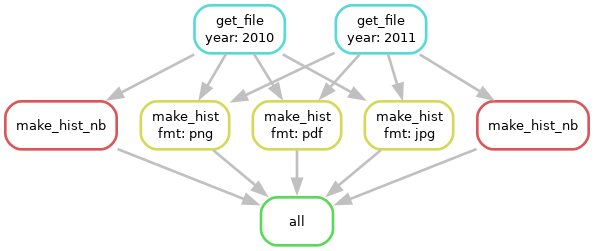

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job             count
------------  -------
all                 1
make_hist_nb        2
total               3

Select jobs to execute...

[Sun Feb 18 18:29:53 2024]
rule make_hist_nb:
    input: dimuon2010.csv, AnalysisNB.ipynb
    output: report2010.html
    jobid: 6
    reason: Updated input files: dimuon2010.csv, AnalysisNB.ipynb
    wildcards: year=2010
    resources: tmpdir=/tmp

[NbConvertApp] Converting notebook AnalysisNB.ipynb to html
INFO:SwanKernelenv.cleaner:SwanKernelEnv Kernel Extension done
[NbConvertApp] Writing 619470 bytes to report2010.html
[Sun Feb 18 18:30:08 2024]
Finished job 6.
1 of 3 steps (33%) done
Select jobs to execute...

[Sun Feb 18 18:30:08 2024]
rule make_hist_nb:
    input: dimuon2011.csv, AnalysisNB.ipynb
    output: report2011.html
    jobid: 7
    reason: Updated input files: dimuon2011.csv,

In [29]:
!env/bin/snakemake -s Snakefile.dimuon --forceall --dag | dot -Tpng > dag.png
display(Image.open("dag.png"))
!env/bin/snakemake -j 1 -s Snakefile.dimuon --force

### Snakemake-dedicated scripts: the snakemake object

If the code you are developing is actually part of the workflow itself and makes no or little sense as an independent software, it is a good idea to define it as a [Snakemake script](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#python).

It is possible to refer to wildcards and params in the script path, *e.g.* by specifying `"scripts/{params.scriptname}.py"` or `"scripts/{wildcards.scriptname}.py"`.

Inside the script, you have access to an object snakemake that provides access to the same objects that are available in the run and shell directives: 
 * `input`
 * `output`
 * `params`
 * `wildcards`
 * `log`
 * `threads`
 * `resources`
 * `config`

For example, one can use `snakemake.input['csv_file]` to access the input object named `csv_file`.


Let's create a simple script that merge the 2010 and 2011 datasets and then split the dataset in lines applying pandas queries obtained from the workflow itself. 



In [79]:
%%writefile merge_and_split.py

import pandas as pd 
import os

## Space-separated input CSV files
INPUT_FILES = snakemake.input['csv_file']

## Output CSV file name
OUTPUT_FILE = snakemake.output["csv_file"]

## Optional selection string
SELECTION = snakemake.params["selection"]

## Read and concatenate the CSV files
df = pd.concat([pd.read_csv(f)[["M"]] for f in INPUT_FILES])

## Optionally, apply selection
if SELECTION is not None:
    df = df.query(SELECTION)

## Output CSV file
df.to_csv(OUTPUT_FILE)

Overwriting merge_and_split.py


Then we will add to our `Snakefile` a mapping for the `SELECTIONS` defining various bins of the invariant mass of the dimuons
```python
SELECTIONS = {
    "Jpsi": "M > 3.0 and M < 3.2",
    "Upsilon": "M > 9 and M < 11",
    "Z": "M > 80 and M < 100",
}
```

The rule will now use the `script:` directive instead of `shell`, but the rest is pretty standard:
```python
rule select_bin:
    input: 
        csv_file=expand("dimuon{year}.csv", year=DATASETS.keys()),
        script="merge_and_split.py",
    
    output:
        csv_file=temporary("{bin}.csv")

    params:
        selection=lambda w: SELECTIONS[w['bin']]

    script: "merge_and_split.py"
```

All together, one gets the following code.

In [31]:
%%writefile Snakefile.binned_dimuon

DATASETS = {
    "2010": "https://opendata.cern.ch/record/303/files/dimuon.csv",
    "2011": "https://opendata.cern.ch/record/5202/files/Dimuon_SingleMu.csv",
}

SELECTIONS = {
    "Jpsi": "M > 3.0 and M < 3.2",
    "Upsilon": "M > 9 and M < 11",
    "Z": "M > 80 and M < 100",
}

rule all:
    input: expand("report-{bin}.html", bin=SELECTIONS.keys())

rule make_hist_nb:
    input:
        csv_file="{bin}.csv",
        notebook="AnalysisNB.ipynb",

    output:
        report="report-{bin}.html"
      
    shell:
        "INPUT_FILE={input.csv_file} "
        "python3 -m jupyter nbconvert {input.notebook} "
        "--execute "
        "--to html "
        "--output {output.report}  "


rule select_bin:
    input: 
        csv_file=expand("dimuon{year}.csv", year=DATASETS.keys()),
        script="merge_and_split.py",
    
    output:
        csv_file=temporary("{bin}.csv")

    params:
        selection=lambda w: SELECTIONS[w['bin']]

    script: "merge_and_split.py"


rule get_file:
    output:
      csv_file="dimuon{year}.csv"

    params:
        url=lambda w: DATASETS[w['year']]
      
    shell:
        "wget {params.url} -qO {output.csv_file}"


Overwriting Snakefile.binned_dimuon


Building DAG of jobs...


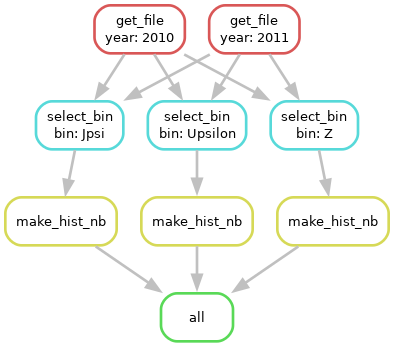

In [32]:
!env/bin/snakemake -s Snakefile.binned_dimuon --forceall --dag | dot -Tpng > dag.png
Image.open("dag.png")

In [33]:
!env/bin/snakemake -j 1 -s Snakefile.binned_dimuon --forceall

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job             count
------------  -------
all                 1
get_file            2
make_hist_nb        3
select_bin          3
total               9

Select jobs to execute...

[Sun Feb 18 18:30:24 2024]
rule get_file:
    output: dimuon2010.csv
    jobid: 3
    reason: Forced execution
    wildcards: year=2010
    resources: tmpdir=/tmp

[Sun Feb 18 18:30:28 2024]
Finished job 3.
1 of 9 steps (11%) done
Select jobs to execute...

[Sun Feb 18 18:30:28 2024]
rule get_file:
    output: dimuon2011.csv
    jobid: 4
    reason: Forced execution
    wildcards: year=2011
    resources: tmpdir=/tmp

[Sun Feb 18 18:30:30 2024]
Finished job 4.
2 of 9 steps (22%) done
Select jobs to execute...

[Sun Feb 18 18:30:30 2024]
rule select_bin:
    input: dimuon2010.csv, dimuon2011.csv, merge_and_split.py
    output: Upsilon.csv
    jobid: 

## Advanced topics: configuration

We discussed how to define complicated workflows that can be used to parallelize a complex data analysis and focus the development on some specific task while remaining connected to the whole workflow, but to make the code **reusable*** we need one further step: **we need to separate the definition of the workflow from its configuration**.

Actually, there is more than one configuration that we can think of:
 * a configuration of the workflow
 * a configuration of the computing environment.
   
The two should remain separate, as one may want to run the same workflow on different hardware or reuse the configuration for a specific hardware to run a slightly different workload.

Both configuration can be defined in **YAML files** (or JSON if you have masochist traits in your personality).



### Workflow configuration

In the example we discussed above, it makes sense to separate the definition of the workflow from the mappings of datasets and selections. These are workflow configurations and should remain separate from the list of rules and inter-dependencies. 

We will write then in a separate YAML file, named **`config.binned_dimuon.yaml`** as it follows.

In [34]:
%%writefile config.binned_dimuon.yaml

datasets:
    "2010": "https://opendata.cern.ch/record/303/files/dimuon.csv"
    "2011": "https://opendata.cern.ch/record/5202/files/Dimuon_SingleMu.csv"

selections:
    Jpsi:    "M > 3.0 and M < 3.2"
    Upsilon: "M > 9 and M < 11"
    Z:       "M > 80 and M < 100"



Overwriting config.binned_dimuon.yaml


Then we define the default config file in the Snakefile.

You can then **extend** the default dictionary by passing another configuration file with the command line option `--configfile <some/file.yaml>`or edit single entries using the `--config` argument. [Refer to the docs](https://snakemake.readthedocs.io/en/stable/snakefiles/configuration.html) for instructions. 

In [35]:
%%writefile Snakefile.binned_dimuon

configfile: "config.binned_dimuon.yaml"

rule all:
    input: expand("report-{bin}.html", bin=config['selections'].keys())

rule make_hist_nb:
    input:
        csv_file="{bin}.csv",
        notebook="AnalysisNB.ipynb",

    log:
        html_report="report-{bin}.html"
      
    shell:
        "INPUT_FILE={input.csv_file} "
        "python3 -m jupyter nbconvert {input.notebook} "
        "--execute "
        "--to html "
        "--output {log.html_report}  "


rule select_bin:
    input: 
        csv_file=expand("dimuon{year}.csv", year=config['datasets'].keys()),
        script="merge_and_split.py",
    
    output:
        csv_file=temporary("{bin}.csv")

    params:
        selection=lambda w: config['selections'][w['bin']]

    script: "merge_and_split.py"


rule get_file:
    output:
      csv_file="dimuon{year}.csv"

    params:
        url=lambda w: config['datasets'][w['year']]
      
    shell:
        "wget {params.url} -qO {output.csv_file}"


Overwriting Snakefile.binned_dimuon


Building DAG of jobs...


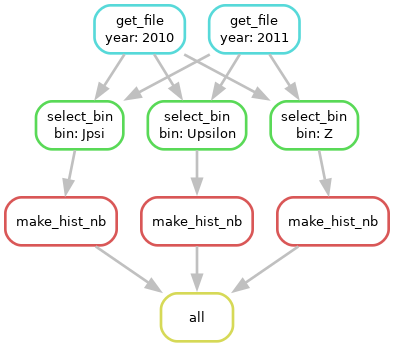

In [36]:
!env/bin/snakemake -s Snakefile.binned_dimuon --forceall --dag | dot -Tpng > dag.png
Image.open("dag.png")

Now, let's add a selection, for example for the $\psi(2S)$ state. Let's start defining a config file.

In [80]:
%%writefile config.psi2s.yaml

selections:
    psi2S: M > 3.6 and M < 3.8

Writing config.psi2s.yaml


Config file config.binned_dimuon.yaml is extended by additional config specified via the command line.
Building DAG of jobs...


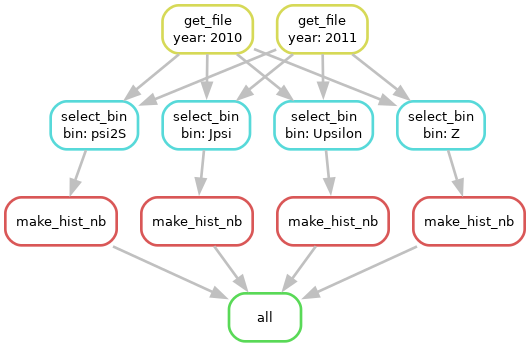

In [81]:
!env/bin/snakemake -s Snakefile.binned_dimuon --forceall --dag --configfile config.psi2s.yaml | dot -Tpng > dag.png
Image.open("dag.png")

Very similar result can be obtained modifying the configuration from the command line.

Config file config.binned_dimuon.yaml is extended by additional config specified via the command line.
Building DAG of jobs...


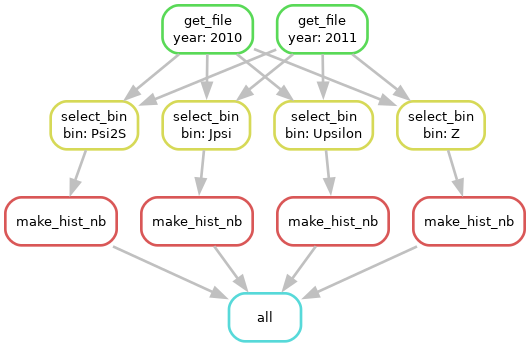

In [37]:
!env/bin/snakemake -s Snakefile.binned_dimuon --forceall --dag --config selections='{"Psi2S": "M > 3.6 and M < 3.8"}' | dot -Tpng > dag.png
Image.open("dag.png")

In [82]:
!env/bin/snakemake -s Snakefile.binned_dimuon -j1 --config selections='{"Psi2S": "M > 3.6 and M < 3.8"}'

Config file config.binned_dimuon.yaml is extended by additional config specified via the command line.
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2024-02-18T210313.689807.snakemake.log


### Execution configuration

Let's move now to discuss the configuration of the execution. 

To modify the way the code is executed we need to insert some configurable layer between the Snakemake sumbission of the task to the compute backend and the actual execution.

Since this feature is mainly used to customize the submission procedure to some computing cluster, this feature goes under the name of `cluster execution`. 

> **Note.** We are in a phase of breaking changes while Snakemake 7 is no longer maintained and Snakemake 8 changes a bit the syntax. Here we are using Snakemake 7, while trying to avoid configuration elements for which it is not clear how to migrate towards Snakemake 8.

To make a simple example of how we can modify the submission mechanism without introducing batch system and other workflow managements, we will just change the priority of the submitted jobs with the [`nice` Linux command](https://en.wikipedia.org/wiki/Nice_(Unix)). 

The nice value indicates how a process should be *nice* to others: in practice a higher nice value means lower priority. A negative nice value (requires being administrator) means higher-than-normal priority and should not be used for computing-intense tasks.

Let's write our custom submission handler with a flag to set the nice value.

> **Exercise.** Try to modify the submission script to introduce a different nice value for different rules.

In [89]:
%%writefile my_exec
#!env/bin/python3 

import os
from argparse import ArgumentParser
from snakemake.utils import read_job_properties

parser = ArgumentParser()
parser.add_argument("script", help="bash script to be executed")
parser.add_argument("--nice", "-n", type=int, default=0, help="nice value")
args = parser.parse_args()

## Note, we are retrieving the properties of the job (such as the name of the rule,
## the requested resources, the inputs and the outputs).
job = read_job_properties(args.script)

## Some logging for monitoring purpose.
print (job, file=open(f"{job['rule']}.log", "w"))

## The real submission with given nice value.
os.system(f"nice -{args.nice} /bin/bash -norc {args.script}")

Overwriting my_exec


And then we configure our Snakemake with a special value of `--nice` in our custom submitter.

In [90]:
!chmod +x my_exec
!env/bin/snakemake \
    --cluster "./my_exec --nice 8" \
    --snakefile Snakefile.binned_dimuon \
    --jobs 8 \
    --forceall 

Building DAG of jobs...
Using shell: /bin/bash
Provided cluster nodes: 8
Job stats:
job             count
------------  -------
all                 1
get_file            2
make_hist_nb        3
select_bin          3
total               9

Select jobs to execute...

[Sun Feb 18 22:05:39 2024]
rule get_file:
    output: dimuon2010.csv
    jobid: 3
    reason: Forced execution
    wildcards: year=2010
    resources: mem_mb=1000, mem_mib=954, disk_mb=1000, disk_mib=954, tmpdir=<TBD>

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 28
Rules claiming more threads will be scaled down.
Provided resources: mem_mb=1000, mem_mib=954, disk_mb=1000, disk_mib=954
Select jobs to execute...

[Sun Feb 18 22:05:41 2024]
rule get_file:
    output: dimuon2010.csv
    jobid: 0
    reason: Forced execution
    wildcards: year=2010
    resources: mem_mb=1000, mem_mib=954, disk_mb=1000, disk_mib=954, tmpdir=/tmp

[Sun Feb 18 22:05:45 2024]
Finished job 0.
1 of 1 steps (100%) done

[Sun Feb 18 2

# Conclusion

Snakemake is a powerful tool to define workflow and provides a rudimental runtime to manage parallel execution of the DAG on both local and cluster resources. 

More advanced workflow management tools exists but they are often less oriented to data analysis and numerical application development and rather to automation, which is subject to slightly different challenges.
You may want to check at least:
 * MLFlow, https://mlflow.org/
 * Apache Airflow, https://airflow.apache.org/
 * NextFlow, https://www.nextflow.io/
 * KubeFlow, https://www.kubeflow.org/

Some of these tools can also be used as backend for cluster execution of Snakemake-defined workflows.